## Brain Tumor detection using classical Machine Learning Algorithms
Refered to the research papers:

 https://www.techrxiv.org/users/688056/articles/680530-brain-tumor-mri-identification-and-classification-using-dwt-pca-and-ksvm


 https://www.sciencedirect.com/science/article/pii/S1877050918301297?ref=cra_js_challenge&fr=RR-1



In [1]:
# Import necessary libraries
import cv2
import numpy as np
import pywt
import os
import seaborn as sns
from skimage.feature import local_binary_pattern
from skimage import exposure, util
from skimage.feature import hog
from skimage.feature import graycoprops as GreyCoPorops
from skimage.feature import graycomatrix as GrayCoMatrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## 1. Download Data
#### Make sure to upload your Kaggle credentials "kaggle.json" before running the below cell !
The below cell
- sets up a Kaggle environment to download a dataset for brain tumor detection
-  extracts the dataset, organizes it into a "data" directory with subdirectories for positive and negative samples


In [2]:
!pip install kaggle -q

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

!kaggle datasets download -d ahmedhamada0/brain-tumor-detection

!unzip -qo brain-tumor-detection.zip
!mkdir data
!cp -r yes data
!cp -r no data

# !rm -r no
# !rm -r yes

 95% 80.0M/84.0M [00:00<00:00, 193MB/s]
100% 84.0M/84.0M [00:00<00:00, 189MB/s]


## 2. Load data into lists

In [3]:
#  loading the images from the "data" directory into two separate lists: tumor_images and no_tumor_images
tumor_images = []
no_tumor_images = []

data_loc = os.path.join('data', 'yes')
for img_loc in os.listdir(data_loc):
    img = cv2.imread(os.path.join(data_loc, img_loc))
    tumor_images.append(img)

data_loc = os.path.join('data', 'no')
for img_loc in os.listdir(data_loc):
    img = cv2.imread(os.path.join(data_loc, img_loc))
    no_tumor_images.append(img)

## 3. Define helper functions

In [ ]:
def GrayIt(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def get_wavelet_subbands(image, wavelet_method='db5'):
    """
      Extracts wavelet subbands (LL, LH, HL, HH) from the input image using the specified wavelet method.

      Parameters:
        image: Input image.
        wavelet_method : Wavelet method to use for decomposition. Default = 'db5'.

      Returns:
        tuple: A tuple containing the wavelet subbands (LL, LH, HL, HH).
                                                                                                          """

    if len(image.shape) > 2:
        gray_image = GrayIt(image)
    else:
        gray_image = image

    coeffs2 = pywt.dwt2(gray_image, wavelet_method)
    LL, (LH, HL, HH) = coeffs2
    LL_scaled = exposure.rescale_intensity(LL, out_range=(0, 1))
    LH_scaled = exposure.rescale_intensity(LH, out_range=(0, 1))
    HL_scaled = exposure.rescale_intensity(HL, out_range=(0, 1))
    HH_scaled = exposure.rescale_intensity(HH, out_range=(0, 1))
    LL_uint8 = util.img_as_ubyte(LL_scaled)
    LH_uint8 = util.img_as_ubyte(LH_scaled)
    HL_uint8 = util.img_as_ubyte(HL_scaled)
    HH_uint8 = util.img_as_ubyte(HH_scaled)

    return LL_uint8, LH_uint8, HL_uint8, HH_uint8


def extract_glcm_features(image):
    """
          Calculates texture features from a grayscale image using GLCM (Gray-Level Co-occurrence Matrix).

      Parameters:
          image (numpy.ndarray): A grayscale image for feature extraction.

      Returns:
          list: A list of texture features extracted from the input image.
                                                                                          """

    distances = [1, 2]  # distance between pixels (1 pixel apart)
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # angles for which to compute GLCM
    glcm = GrayCoMatrix(image, distances, angles, levels=256, symmetric=True, normed=True)

    # the 6 GLCM properties to calculate
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

    glcm_features = []
    for prop in properties:
        feature = GreyCoPorops(glcm, prop)
        glcm_features.extend(feature.flatten())

    return glcm_features


def extract_lbp_features(image, radius=2, n_sampling_points=8):
    """
      Calculates Local Binary Pattern (LBP) features from a grayscale image.

      Args:
          image : image

      Returns:
          numpy.ndarray: 1D LBP feature histogram.

    """
    if len(image.shape) > 2:
        gray_image = GrayIt(image)
    else:
        gray_image = image

    n_points = n_sampling_points * radius
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    return hist


def extract_dwt_features(image, wavelet_method='db5'):
    """
    Extracts features using Discrete Wavelet Transform (DWT) and Gray Level Co-occurrence Matrix (GLCM) for a given image.

    Parameters:
    - image: the input image
    - wavelet_method: default = 'db5', the type of wavelet to be used for DWT

    Returns:
    - combined_features: the list containing GLCM features extracted from different subbands of the DWT and the image itself.
                                                                                                                                """

    LL, LH, HL, HH = get_wavelet_subbands(image, wavelet_method)
    combined_features = []
    combined_features.append(extract_glcm_features(LL))
    combined_features.append(extract_glcm_features(LH))
    combined_features.append(extract_glcm_features(HL))
    combined_features.append(extract_glcm_features(HH))
    combined_features.append(extract_glcm_features(image))

    return combined_features


def extract_dwt_lbp_features(image, wavelet_method='db5'):
    """
    Extracts features using Discrete Wavelet Transform (DWT), Gray Level Co-occurrence Matrix (GLCM), and Local Binary Patterns (LBP) for a given image.

    Parameters:
      - image: the input image
      - wavelet_method: default = 'db5', the type of wavelet to be used for DWT

    Returns:
    - combined_features: the list containing GLCM features extracted from different subbands of the DWT along with LBP features
                                                                                                                                                    """

    LL, LH, HL, HH = get_wavelet_subbands(image, wavelet_method)
    combined_features = []
    combined_features.append(extract_glcm_features(LL))
    combined_features.append(extract_glcm_features(LH))
    combined_features.append(extract_glcm_features(HL))
    combined_features.append(extract_glcm_features(HH))
    combined_features.append(extract_glcm_features(image))
    # Extract LBP features
    lbp_features1 = extract_lbp_features(LL)
    lbp_features2 = extract_lbp_features(LH)
    lbp_features3 = extract_lbp_features(HL)
    lbp_features4 = extract_lbp_features(HH)

    combined_features.append(lbp_features1)
    combined_features.append(lbp_features2)
    combined_features.append(lbp_features3)
    combined_features.append(lbp_features4)
    combined_features.append(extract_lbp_features(image))

    return combined_features


def extract_features(images, feature_extraction_method='dwt', wavelet_method='db5'):
    features = []
    for img in images:
        if feature_extraction_method == 'dwt':
            img_features = extract_dwt_features(GrayIt(img), wavelet_method)
        elif feature_extraction_method == 'dwt_lbp':
            img_features = extract_dwt_lbp_features(GrayIt(img), wavelet_method)
        else:
            raise ValueError("Invalid feature extraction method. Choose 'dwt' or 'dwt_lbp'.")
        features.append(img_features)

    return np.array([np.concatenate(sublist) for sublist in features])

In [ ]:
def apply_pca(data, n_components=None):
  """
  Applies PCA (Principal Component Analysis) to a dataset.

  Args:
      data: A 2D NumPy array representing the data to be transformed.
      n_components (optional): The number of principal components to retain.

  Returns:
          - transformed_data: The data transformed into the principal component space.
  """

  pca = PCA(n_components=n_components)
  pca.fit(data)
  transformed_data = pca.transform(data)

  return transformed_data

## 4. Feature extraction and Train-Test split
- Case 1: Only GLCM features(DWT + GLCM)
- Case 2: GLCM + LBP features(DWT + GLCM + LBP)

In [ ]:
# Extract features
X_tumor_main = extract_features(tumor_images)
X_no_tumor_image = extract_features(no_tumor_images)

### Principal Component Analysis applied
- Define the number of components here

In [ ]:
# Apply PCA using defined Number of components
NOC = 20
X_tumor=apply_pca(X_tumor_main, n_components=NOC)
X_no_tumor_image_ = apply_pca(X_no_tumor_image, n_components=NOC)

In [ ]:
# Assign Labels
Y_tumor=np.ones(len(X_tumor))
Y_no_tumor_image=np.zeros(len(X_no_tumor_image))

In [ ]:
# Train-test split
X=np.vstack((X_tumor,X_no_tumor_image_))
Y=np.hstack((Y_tumor,Y_no_tumor_image))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## 5. Evaluation using different classifiers

In [ ]:
# KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_accuracy = knn_classifier.score(X_test, y_test)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.885


In [ ]:
# Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=120)
rf_classifier.fit(X_train, y_train)
rf_accuracy = rf_classifier.score(X_test, y_test)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.97


In [ ]:
# AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_classifier.fit(X_train, y_train)
adaboost_accuracy = adaboost_classifier.score(X_test, y_test)
print("AdaBoost Classifier Accuracy:", adaboost_accuracy)


AdaBoost Classifier Accuracy: 0.735


In [ ]:
def grid_search_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 120],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    rf_clf = RandomForestClassifier(random_state=42)

    grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='recall', verbose=2, n_jobs=-1)

    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)

    return grid_search.best_estimator_



def evaluate_classifier(clf, X_train, y_train, X_test, y_test, classifier_name):
    clf.fit(X_train, y_train)

    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)

    train_accuracy = accuracy_score(y_train, train_preds)
    train_precision = precision_score(y_train, train_preds, average='weighted')
    train_recall = recall_score(y_train, train_preds, average='weighted')
    train_f1 = f1_score(y_train, train_preds, average='weighted')

    test_accuracy = accuracy_score(y_test, test_preds)
    test_precision = precision_score(y_test, test_preds, average='weighted')
    test_recall = recall_score(y_test, test_preds, average='weighted')
    test_f1 = f1_score(y_test, test_preds, average='weighted')

    print("Classifier:", classifier_name)
    print("Train Accuracy:", train_accuracy)
    print("Train Precision:", train_precision)
    print("Train Recall:", train_recall)
    print("Train F1 Score:", train_f1)
    print("Test Accuracy:", test_accuracy)
    print("Test Precision:", test_precision)
    print("Test Recall:", test_recall)
    print("Test F1 Score:", test_f1)

    # Create confusion matrix for test data
    cm = confusion_matrix(y_test, test_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return (train_accuracy, train_precision, train_recall, train_f1,
            test_accuracy, test_precision, test_recall, test_f1, cm)

Classifier: KNN
Train Accuracy: 0.9383333333333334
Train Precision: 0.9392598131739731
Train Recall: 0.9383333333333334
Train F1 Score: 0.9382841138393732
Test Accuracy: 0.885
Test Precision: 0.8876479421579533
Test Recall: 0.885
Test F1 Score: 0.8850220422177222


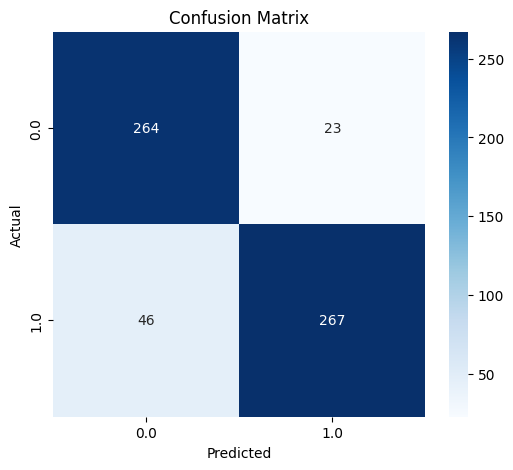

In [ ]:
# KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
results = evaluate_classifier(knn_classifier, X_train, y_train, X_test, y_test, "KNN")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 120}
Classifier: Random Forest
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 Score: 1.0
Test Accuracy: 0.955
Test Precision: 0.9550650723025584
Test Recall: 0.955
Test F1 Score: 0.9550086376926095


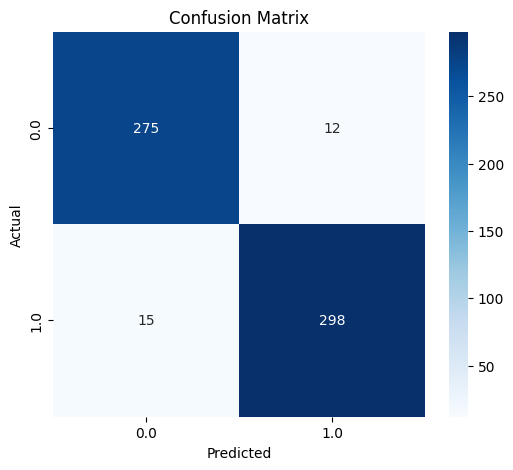

(1.0,
 1.0,
 1.0,
 1.0,
 0.955,
 0.9550650723025584,
 0.955,
 0.9550086376926095,
 array([[275,  12],
        [ 15, 298]]))

In [ ]:
# Random Forest classifier
best_rf_model = grid_search_random_forest(X_train, y_train)
results = evaluate_classifier(best_rf_model, X_train, y_train, X_test, y_test, "Random Forest")

Classifier: AdaBoost
Train Accuracy: 0.8404166666666667
Train Precision: 0.8412675902323021
Train Recall: 0.8404166666666667
Train F1 Score: 0.8402611083459274
Test Accuracy: 0.77
Test Precision: 0.7746201945086479
Test Recall: 0.77
Test F1 Score: 0.7698261913229019


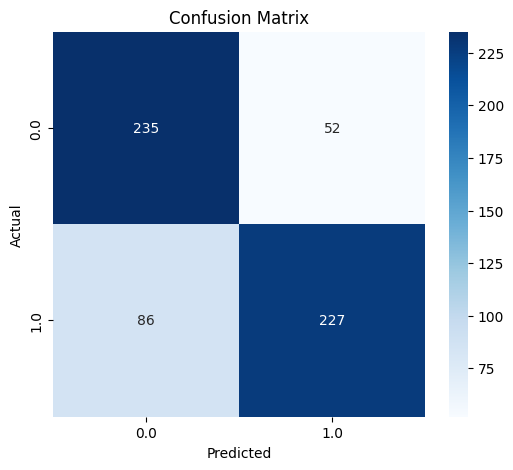

In [ ]:
# AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=100)
results_adaboost = evaluate_classifier(adaboost_classifier, X_train, y_train, X_test, y_test, "AdaBoost")

### Case 2: GLCM + LBP features(DWT + GLCM + LBP)

In [ ]:
# Extract features
X_tumor_main = extract_features(tumor_images, 'dwt_lbp')
X_no_tumor_image = extract_features(no_tumor_images, 'dwt_lbp')

### Principal Component Analysis applied
- Define the number of components here

In [ ]:
# Apply PCA using defined Number of components
NOC=25
X_tumor=apply_pca(X_tumor_main, n_components=NOC)
X_no_tumor_image_ = apply_pca(X_no_tumor_image, n_components=NOC)

In [ ]:
# Assign Labels
Y_tumor=np.ones(len(X_tumor))
Y_no_tumor_image=np.zeros(len(X_no_tumor_image))

In [ ]:
# Train-test split
X=np.vstack((X_tumor,X_no_tumor_image_))
Y=np.hstack((Y_tumor,Y_no_tumor_image))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Evaluation

In [ ]:
# KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_accuracy = knn_classifier.score(X_test, y_test)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.975


In [ ]:
# Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=120)
rf_classifier.fit(X_train, y_train)
rf_accuracy = rf_classifier.score(X_test, y_test)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.9966666666666667


In [ ]:
# AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_classifier.fit(X_train, y_train)
adaboost_accuracy = adaboost_classifier.score(X_test, y_test)
print("AdaBoost Classifier Accuracy:", adaboost_accuracy)


AdaBoost Classifier Accuracy: 0.9616666666666667


Classifier: KNN
Train Accuracy: 0.9858333333333333
Train Precision: 0.9858382208883125
Train Recall: 0.9858333333333333
Train F1 Score: 0.9858330381483218
Test Accuracy: 0.975
Test Precision: 0.9750367712604744
Test Recall: 0.975
Test F1 Score: 0.9749939441862796


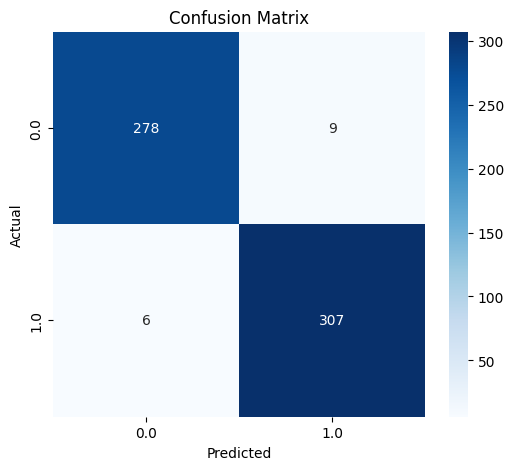

In [ ]:
# KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
results = evaluate_classifier(knn_classifier, X_train, y_train, X_test, y_test, "KNN")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Classifier: Random Forest
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 Score: 1.0
Test Accuracy: 0.995
Test Precision: 0.995004788205425
Test Recall: 0.995
Test F1 Score: 0.9949996242390842


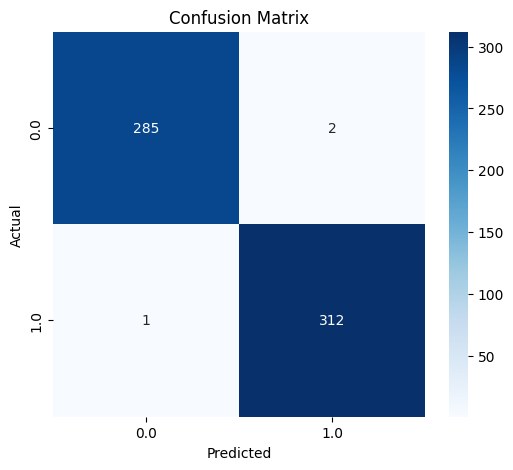

(1.0,
 1.0,
 1.0,
 1.0,
 0.995,
 0.995004788205425,
 0.995,
 0.9949996242390842,
 array([[285,   2],
        [  1, 312]]))

In [ ]:
# Random Forest classifier
best_rf_model = grid_search_random_forest(X_train, y_train)
evaluate_classifier(best_rf_model, X_train, y_train, X_test, y_test, "Random Forest")

Classifier: AdaBoost
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 Score: 1.0
Test Accuracy: 0.9783333333333334
Test Precision: 0.9783355232877526
Test Recall: 0.9783333333333334
Test F1 Score: 0.9783317050360313


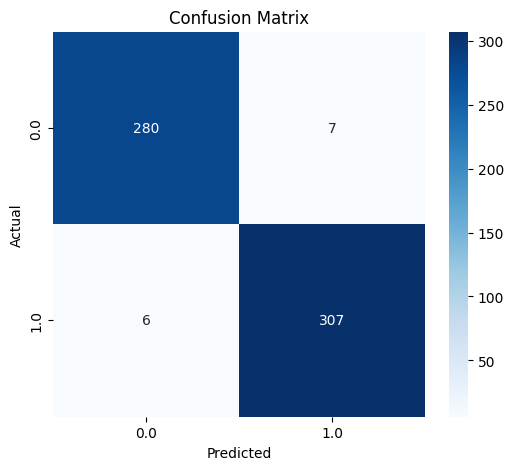

In [ ]:
# AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=150)
results_adaboost = evaluate_classifier(adaboost_classifier, X_train, y_train, X_test, y_test, "AdaBoost")

## Illustration of DWT
- Db5 and Haar Wavelets

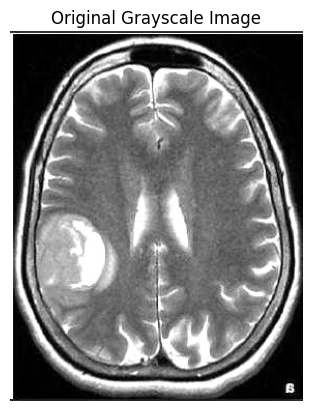

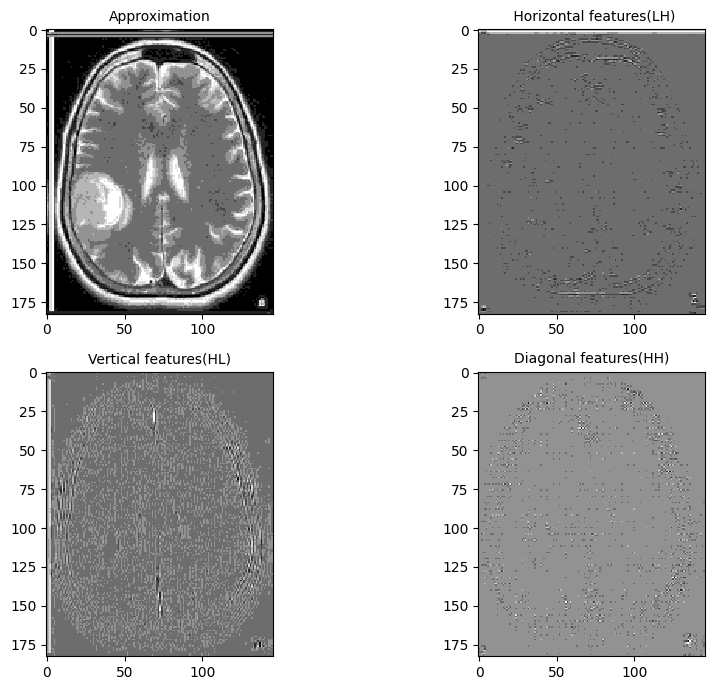

In [11]:
# Load MRI image
mri_image = cv2.cvtColor(tumor_images[0], cv2.COLOR_BGR2GRAY)

plt.imshow(mri_image, cmap='gray')
plt.axis('off')
plt.title('Original Grayscale Image')

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal features(LH)',
          'Vertical features(HL)', 'Diagonal features(HH)']
coeffs2 = pywt.dwt2(mri_image, 'db5')

LL, (LH, HL, HH) = coeffs2

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

# Plot and save coefficients
for i, (coeff, title) in enumerate(zip([LL, LH, HL, HH], titles)):
    row = i // 2
    col = i % 2
    coeff_scaled = exposure.rescale_intensity(coeff, out_range=(0, 1))
    bin_width = 32
    coeff_ = util.img_as_ubyte(coeff_scaled)
    coefficient = coeff_//bin_width
    axes[row, col].imshow(coefficient, interpolation="nearest", cmap=plt.cm.gray)
    axes[row, col].set_title(title, fontsize=10)

plt.tight_layout()
plt.show()

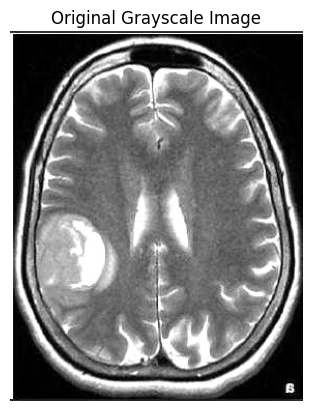

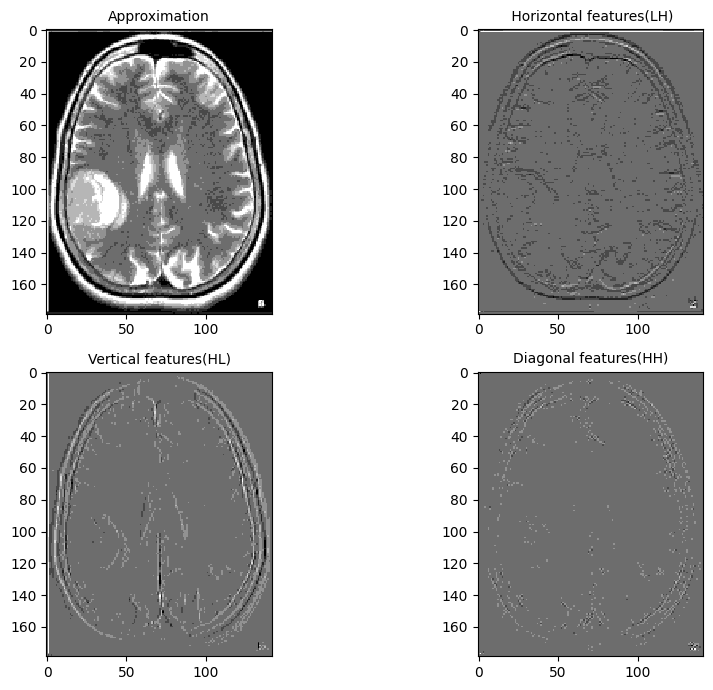

In [12]:
# Load MRI image
mri_image = cv2.cvtColor(tumor_images[0], cv2.COLOR_BGR2GRAY)

plt.imshow(mri_image, cmap='gray')
plt.axis('off')
plt.title('Original Grayscale Image')

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal features(LH)',
          'Vertical features(HL)', 'Diagonal features(HH)']
coeffs2 = pywt.dwt2(mri_image, 'Haar')

LL, (LH, HL, HH) = coeffs2

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

# Plot and save coefficients
for i, (coeff, title) in enumerate(zip([LL, LH, HL, HH], titles)):
    row = i // 2
    col = i % 2
    coeff_scaled = exposure.rescale_intensity(coeff, out_range=(0, 1))
    bin_width = 32
    coeff_ = util.img_as_ubyte(coeff_scaled)
    coefficient = coeff_//bin_width
    axes[row, col].imshow(coefficient, interpolation="nearest", cmap=plt.cm.gray)
    axes[row, col].set_title(title, fontsize=10)

plt.tight_layout()
plt.show()